In [1]:
# #이 코드로 색상 통일하기!
# palette = sns.color_palette("pastel")
# plt.bar(df_amt['purchase_year'], df_amt['purchase_amt'],color=palette[:len(df_amt)])

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import linkage,dendrogram,fcluster
from sklearn.cluster import KMeans, DBSCAN

#경고메세지 무시
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.model_selection import GridSearchCV

In [3]:
%matplotlib inline
#한글 폰트 적용 
matplotlib.rc('font',family='NanumGothic')
plt.rc('font', family='NanumGothic')
plt.rcParams['font.family']='NanumGothic'
#seaborn에서 한글 깨짐 해결: unicode minus 사용하지 않겠다.
plt.rcParams['axes.unicode_minus'] = False

In [4]:
member = \
pd.read_csv('/home/piai/s_1114/Project/Data/jeju_member.csv',encoding='UTF-8')
member.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6013 entries, 0 to 6012
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6013 non-null   object
 1   birth_date      6013 non-null   object
 2   gender          6013 non-null   object
 3   age             6013 non-null   int64 
 4   agegroup        6013 non-null   object
 5   customer_type   6013 non-null   object
 6   customer_grade  6013 non-null   object
 7   gaip_date       6013 non-null   object
 8   taltoi_date     634 non-null    object
 9   member_month    6013 non-null   int64 
 10  gaip_path       6013 non-null   object
 11  flag_member     6013 non-null   object
 12  flag_rcv_sms    6013 non-null   object
 13  flag_rcv_email  6013 non-null   object
 14  flag_rcv_post   6013 non-null   object
 15  zipcode         6013 non-null   object
 16  sigun           6013 non-null   object
 17  dong            6013 non-null   object
 18  ri      

In [5]:
member.head()

,customer_id,birth_date,gender,age,agegroup,customer_type,customer_grade,gaip_date,taltoi_date,member_month,gaip_path,flag_member,flag_rcv_sms,flag_rcv_email,flag_rcv_post,zipcode,sigun,dong,ri,address
0,C102666,1976-11-08,남,44,40대,일반,3Gold,2014-10-07,NaN,63,매장,Y,Y,Y,Y,690-170,제주시,연동,NaN,제주 제주시 연동
1,C118113,1975-08-18,여,45,40대,일반,3Gold,2011-12-06,NaN,97,기타,Y,Y,Y,Y,690-122,제주시,아라2동,NaN,제주 제주시 아라2동
2,C118133,1981-03-20,남,39,30대,일반,4Silver,2011-12-07,2014-04-02,28,매장,N,Y,Y,N,699-900,서귀포시,성산읍,NaN,제주 서귀포시 성산읍
3,C118278,1979-06-22,여,41,40대,일반,3Gold,2011-12-11,NaN,97,인터넷,Y,Y,Y,Y,695-791,제주시,애월읍,광령2리,제주 제주시 애월읍 광령2리 제주관광대학
4,C118280,1959-08-28,남,61,60대,일반,3Gold,2011-12-11,2016-05-02,53,기타,N,N,N,N,699-905,서귀포시,성산읍,삼달리,제주 서귀포시 성산읍 삼달리


## 행정구역 추출------------------------------------------------------

In [6]:
member['my_dong'] = member.apply(lambda member: member['sigun'] if(member['dong'][-1]=='동')else member['dong'],axis=1)
member

,customer_id,birth_date,gender,age,agegroup,customer_type,customer_grade,gaip_date,taltoi_date,member_month,...,flag_member,flag_rcv_sms,flag_rcv_email,flag_rcv_post,zipcode,sigun,dong,ri,address,my_dong
0,C102666,1976-11-08,남,44,40대,일반,3Gold,2014-10-07,NaN,63,...,Y,Y,Y,Y,690-170,제주시,연동,NaN,제주 제주시 연동,제주시
1,C118113,1975-08-18,여,45,40대,일반,3Gold,2011-12-06,NaN,97,...,Y,Y,Y,Y,690-122,제주시,아라2동,NaN,제주 제주시 아라2동,제주시
2,C118133,1981-03-20,남,39,30대,일반,4Silver,2011-12-07,2014-04-02,28,...,N,Y,Y,N,699-900,서귀포시,성산읍,NaN,제주 서귀포시 성산읍,성산읍
3,C118278,1979-06-22,여,41,40대,일반,3Gold,2011-12-11,NaN,97,...,Y,Y,Y,Y,695-791,제주시,애월읍,광령2리,제주 제주시 애월읍 광령2리 제주관광대학,애월읍
4,C118280,1959-08-28,남,61,60대,일반,3Gold,2011-12-11,2016-05-02,53,...,N,N,N,N,699-905,서귀포시,성산읍,삼달리,제주 서귀포시 성산읍 삼달리,성산읍
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6008,C705804,1962-08-13,여,58,50대,일반,2Platinum,2019-12-09,NaN,1,...,Y,Y,Y,Y,697-070,서귀포시,동홍동,NaN,제주 서귀포시 동홍동,서귀포시
6009,C706457,1995-10-12,여,25,20대,일반,4Silver,2019-12-11,NaN,1,...,Y,Y,Y,N,690-781,제주시,화북일동,제주대학교사라캠퍼스,제주 제주시 화북일동 제주대학교사라캠퍼스,제주시
6010,C707942,1986-09-20,여,34,30대,일반,4Silver,2019-12-19,NaN,1,...,Y,Y,N,Y,695-964,제주시,조천읍,신흥리,제주 제주시 조천읍 신흥리,조천읍
6011,C707954,1984-04-20,여,36,30대,일반,3Gold,2019-12-19,NaN,1,...,Y,N,N,N,690-806,제주시,도남동,1~51,제주 제주시 도남동 1~51,제주시


<Figure size 3600x1440 with 0 Axes>

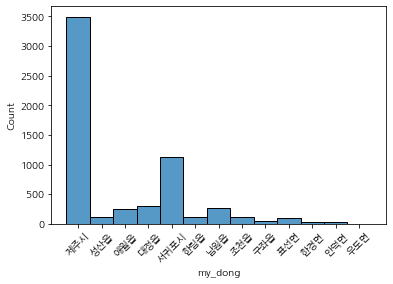

<Figure size 3600x1440 with 0 Axes>

In [7]:

# plt.text(13, 10, '출처')
sns.histplot(x=member['my_dong'])
plt.xticks(rotation=45)
plt.figure(figsize=(50,20))


In [8]:
df_jeju = member[member['my_dong']=='제주시']
df_jeju

,customer_id,birth_date,gender,age,agegroup,customer_type,customer_grade,gaip_date,taltoi_date,member_month,...,flag_member,flag_rcv_sms,flag_rcv_email,flag_rcv_post,zipcode,sigun,dong,ri,address,my_dong
0,C102666,1976-11-08,남,44,40대,일반,3Gold,2014-10-07,NaN,63,...,Y,Y,Y,Y,690-170,제주시,연동,NaN,제주 제주시 연동,제주시
1,C118113,1975-08-18,여,45,40대,일반,3Gold,2011-12-06,NaN,97,...,Y,Y,Y,Y,690-122,제주시,아라2동,NaN,제주 제주시 아라2동,제주시
6,C118288,1972-03-16,남,48,40대,일반,4Silver,2011-12-11,2012-07-30,7,...,N,N,Y,Y,690-042,제주시,용담2동,NaN,제주 제주시 용담2동,제주시
7,C118290,1963-10-17,여,57,50대,일반,3Gold,2011-12-11,NaN,97,...,Y,Y,Y,Y,690-162,제주시,오라2동,NaN,제주 제주시 오라2동,제주시
8,C118291,1962-07-19,여,58,50대,일반,1Royal,2011-12-11,NaN,97,...,Y,Y,N,Y,690-760,제주시,노형동,부영아파트,제주 제주시 노형동 부영아파트,제주시
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6004,C704612,1969-01-28,여,51,50대,일반,3Gold,2019-12-03,NaN,1,...,Y,Y,Y,Y,690-813,제주시,연동,1~271,제주 제주시 연동 1~271,제주시
6005,C704649,1964-10-12,여,56,50대,일반,3Gold,2019-12-02,NaN,1,...,Y,Y,N,N,690-081,제주시,도련1동,NaN,제주 제주시 도련1동,제주시
6006,C704655,1986-08-18,여,34,30대,일반,3Gold,2019-12-04,NaN,1,...,Y,Y,N,Y,690-818,제주시,연동,1906~2515,제주 제주시 연동 1906~2515,제주시
6009,C706457,1995-10-12,여,25,20대,일반,4Silver,2019-12-11,NaN,1,...,Y,Y,Y,N,690-781,제주시,화북일동,제주대학교사라캠퍼스,제주 제주시 화북일동 제주대학교사라캠퍼스,제주시


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(

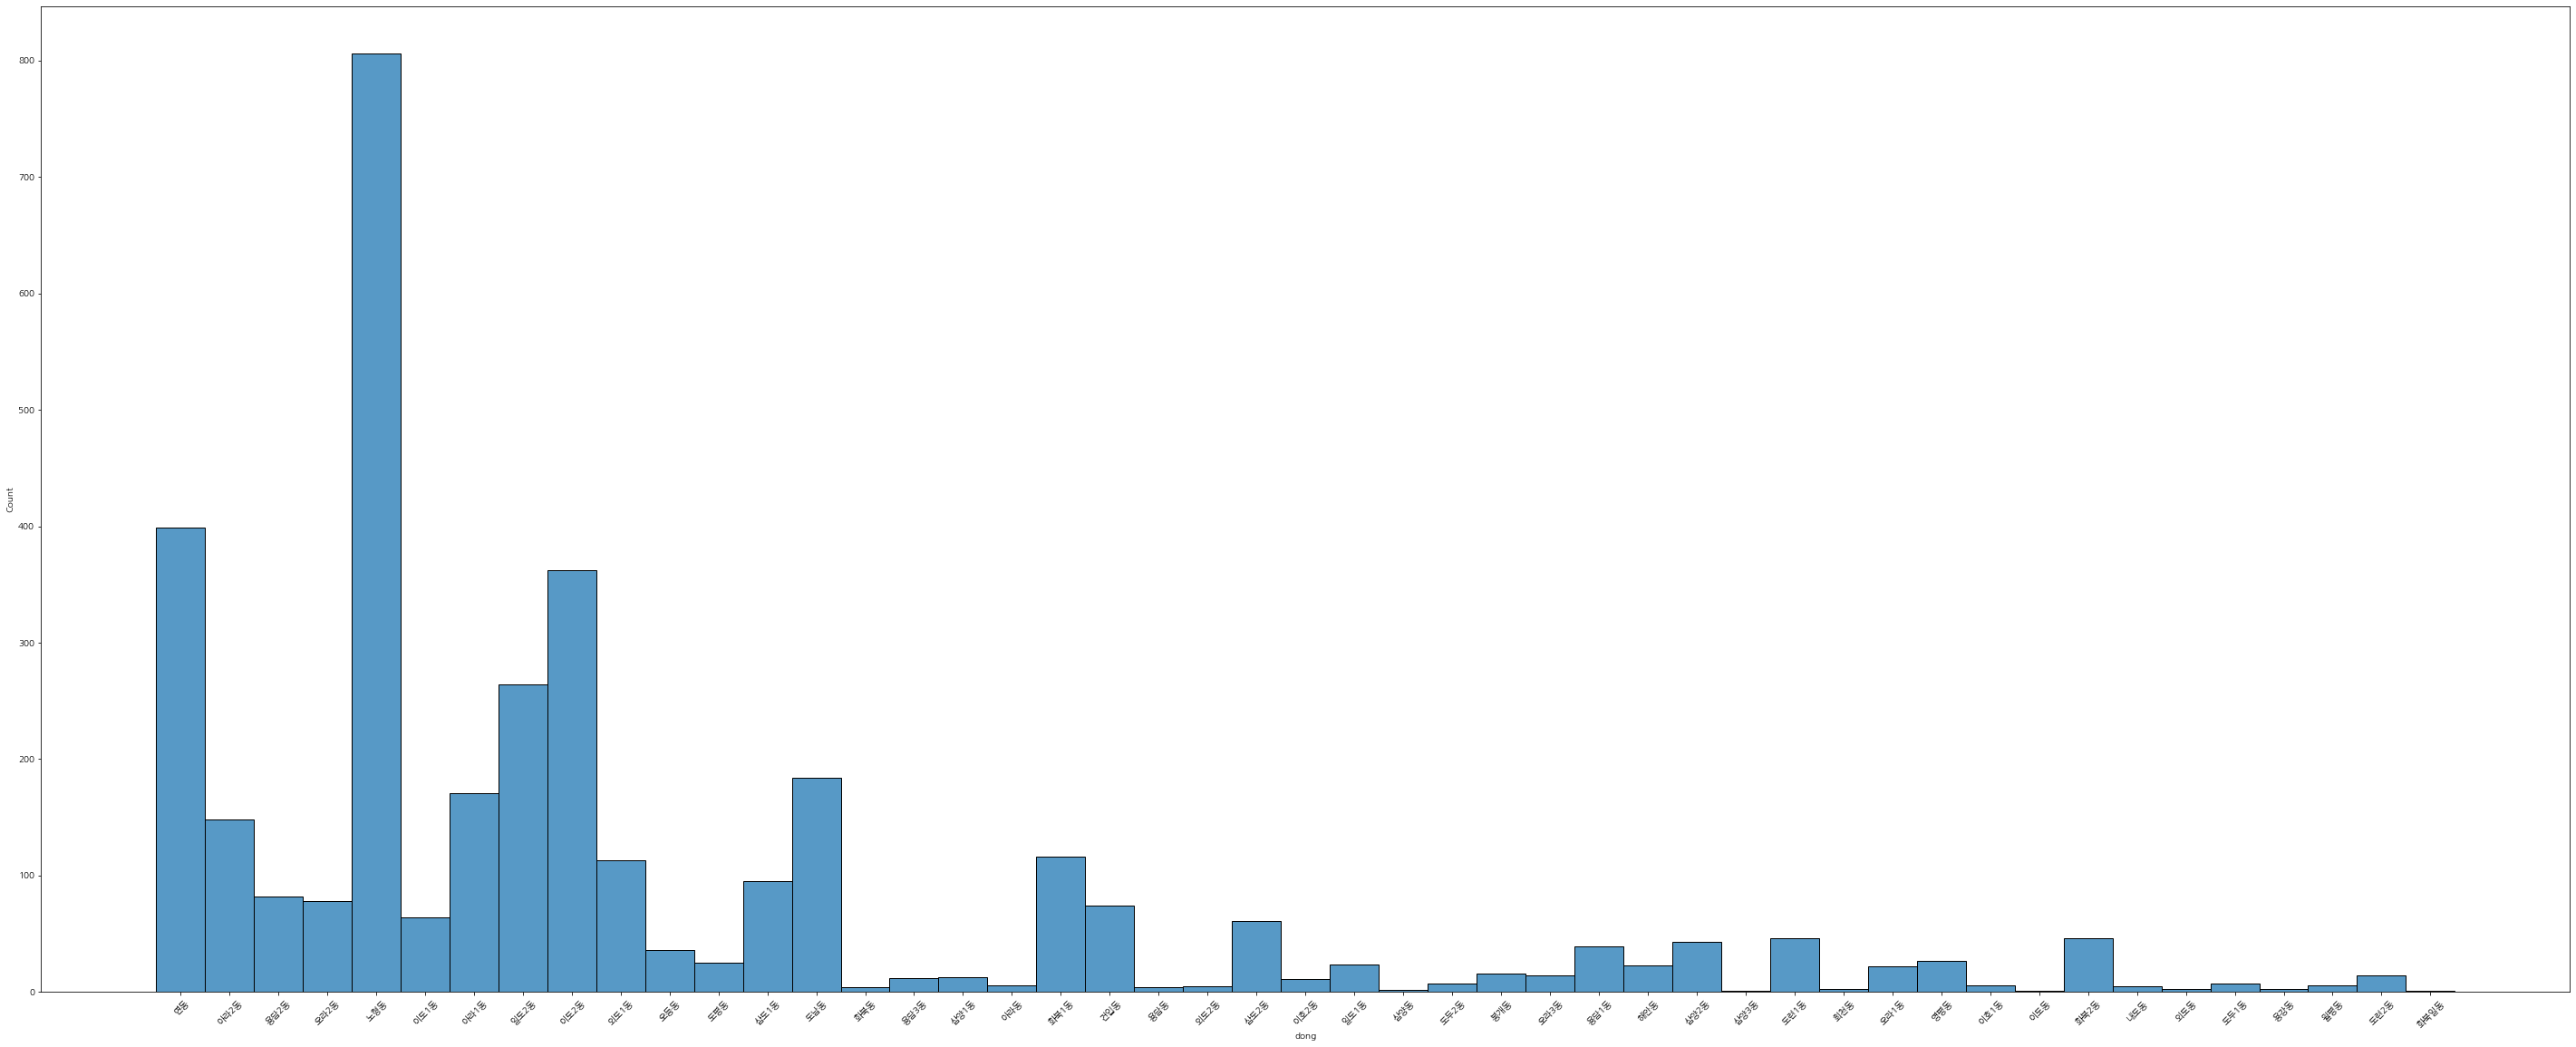

In [9]:
plt.figure(figsize=(50,20))
# sns.set(font_scale=5)
sns.histplot(x=df_jeju['dong'])
plt.xticks(rotation=45)

노형동(매장위치)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

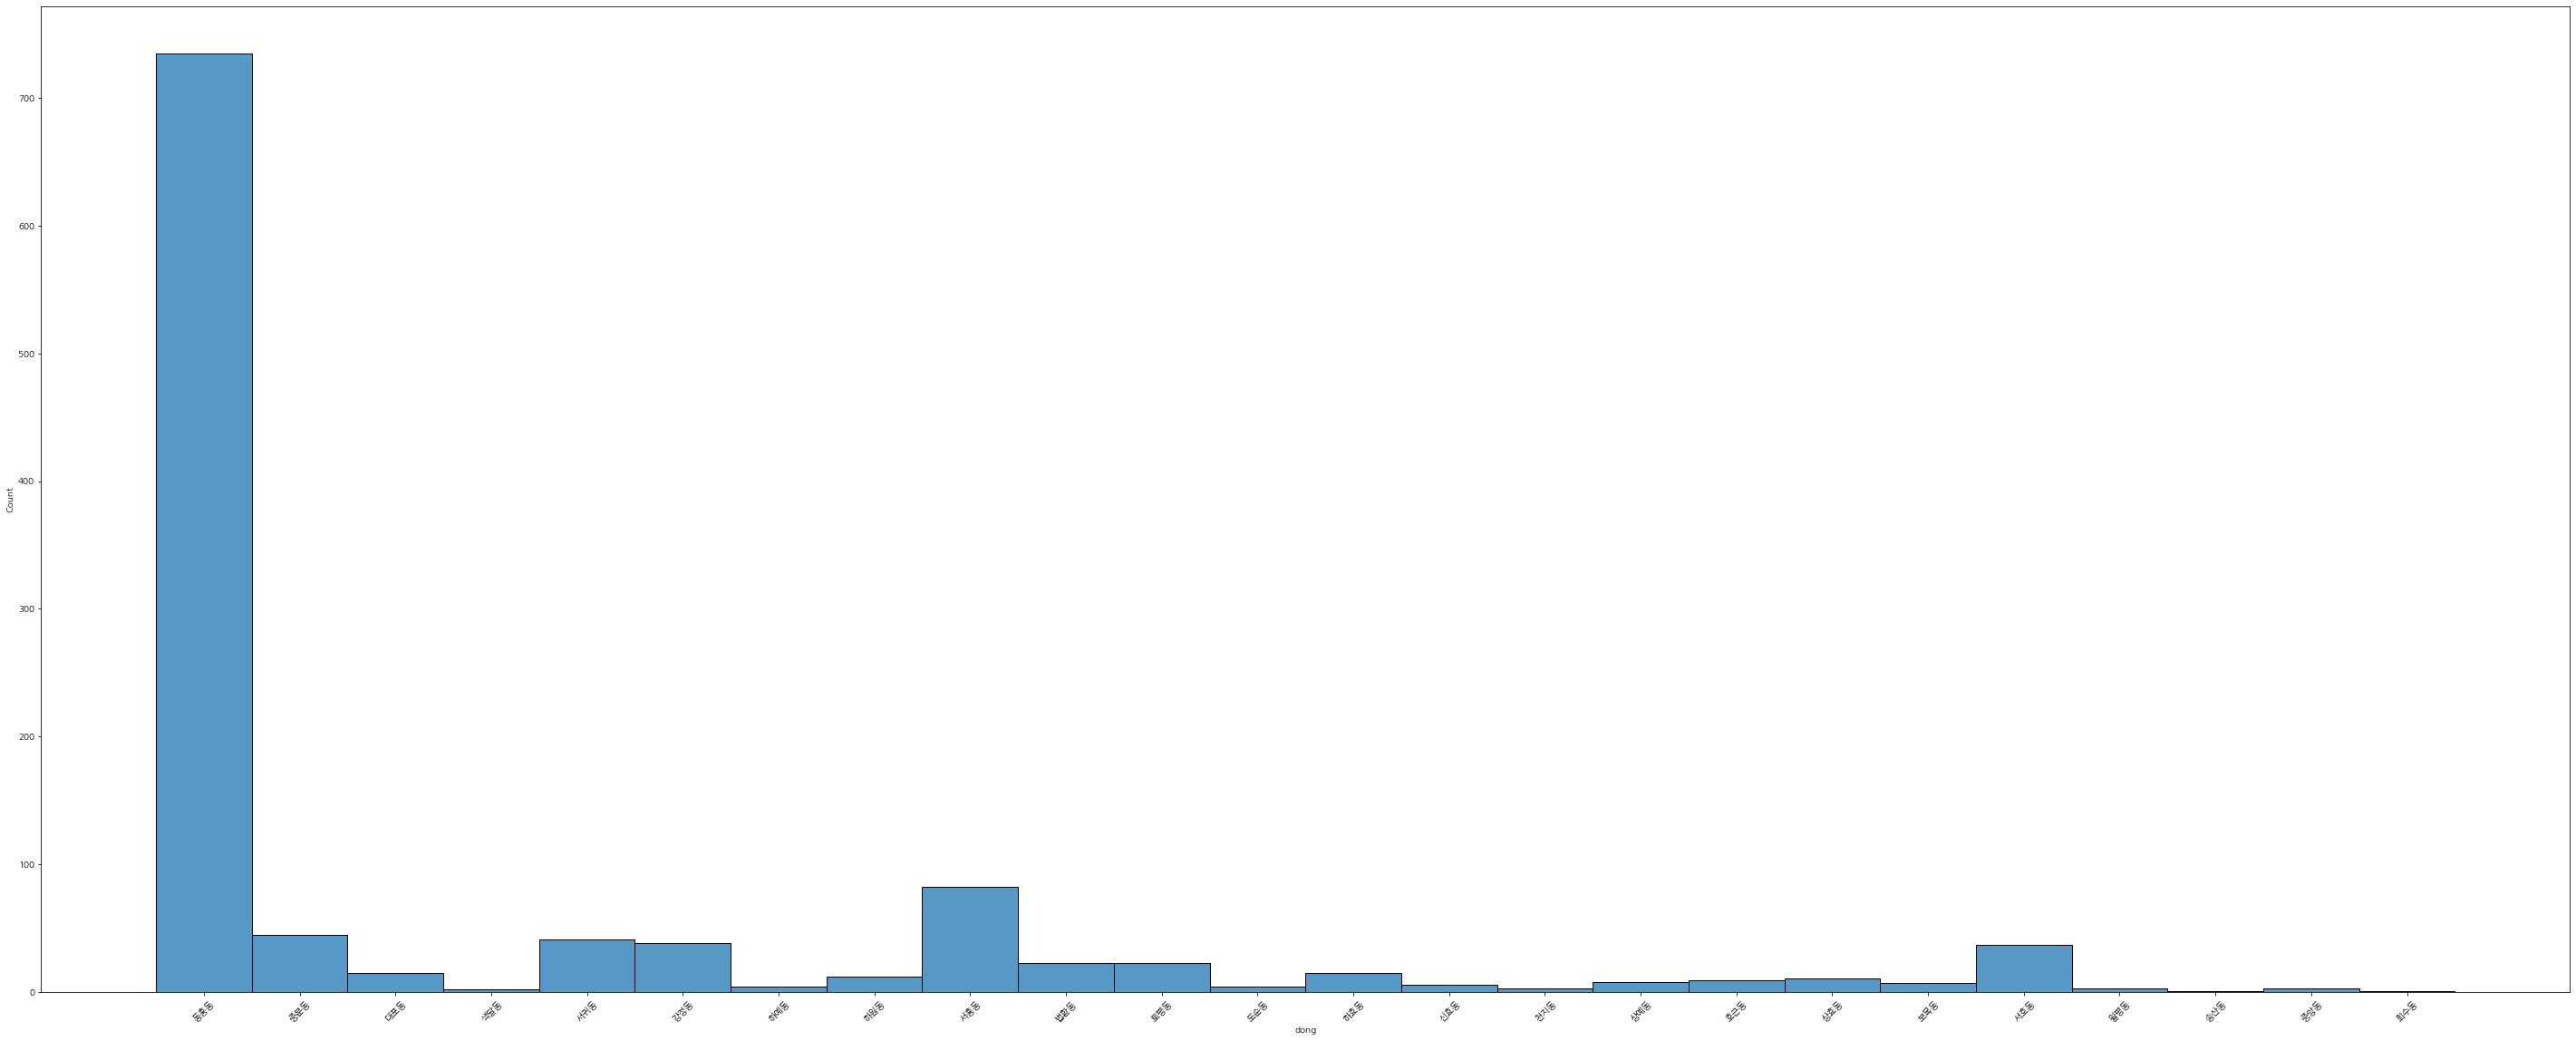

In [10]:
df_seoguipo = member[member['my_dong']=='서귀포시']
plt.figure(figsize=(50,20))
# sns.set(font_scale=5)
sns.histplot(x=df_seoguipo['dong'])
plt.xticks(rotation=45)

동홍동(매장위치)

<AxesSubplot:xlabel='gender', ylabel='Count'>

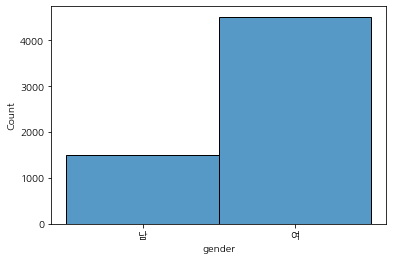

In [11]:
sns.histplot(x=member['gender'])

<AxesSubplot:xlabel='agegroup', ylabel='Count'>

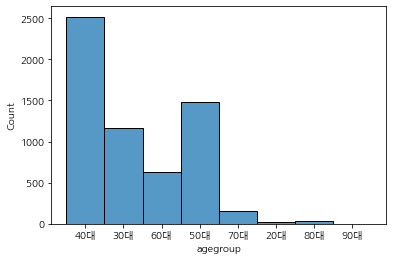

In [12]:
sns.histplot(x=member['agegroup'])

In [13]:
member

,customer_id,birth_date,gender,age,agegroup,customer_type,customer_grade,gaip_date,taltoi_date,member_month,...,flag_member,flag_rcv_sms,flag_rcv_email,flag_rcv_post,zipcode,sigun,dong,ri,address,my_dong
0,C102666,1976-11-08,남,44,40대,일반,3Gold,2014-10-07,NaN,63,...,Y,Y,Y,Y,690-170,제주시,연동,NaN,제주 제주시 연동,제주시
1,C118113,1975-08-18,여,45,40대,일반,3Gold,2011-12-06,NaN,97,...,Y,Y,Y,Y,690-122,제주시,아라2동,NaN,제주 제주시 아라2동,제주시
2,C118133,1981-03-20,남,39,30대,일반,4Silver,2011-12-07,2014-04-02,28,...,N,Y,Y,N,699-900,서귀포시,성산읍,NaN,제주 서귀포시 성산읍,성산읍
3,C118278,1979-06-22,여,41,40대,일반,3Gold,2011-12-11,NaN,97,...,Y,Y,Y,Y,695-791,제주시,애월읍,광령2리,제주 제주시 애월읍 광령2리 제주관광대학,애월읍
4,C118280,1959-08-28,남,61,60대,일반,3Gold,2011-12-11,2016-05-02,53,...,N,N,N,N,699-905,서귀포시,성산읍,삼달리,제주 서귀포시 성산읍 삼달리,성산읍
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6008,C705804,1962-08-13,여,58,50대,일반,2Platinum,2019-12-09,NaN,1,...,Y,Y,Y,Y,697-070,서귀포시,동홍동,NaN,제주 서귀포시 동홍동,서귀포시
6009,C706457,1995-10-12,여,25,20대,일반,4Silver,2019-12-11,NaN,1,...,Y,Y,Y,N,690-781,제주시,화북일동,제주대학교사라캠퍼스,제주 제주시 화북일동 제주대학교사라캠퍼스,제주시
6010,C707942,1986-09-20,여,34,30대,일반,4Silver,2019-12-19,NaN,1,...,Y,Y,N,Y,695-964,제주시,조천읍,신흥리,제주 제주시 조천읍 신흥리,조천읍
6011,C707954,1984-04-20,여,36,30대,일반,3Gold,2019-12-19,NaN,1,...,Y,N,N,N,690-806,제주시,도남동,1~51,제주 제주시 도남동 1~51,제주시


## 군집분석
### 계층형--------------------------------------------------------------------------------------------------------

In [14]:
# member_for_scale = member[['gender','age','customer_type','my_dong']]
# member_for_scale

In [15]:
# member_for_scale['gender'] = np.where(member_for_scale['gender']=='여', 1,0)
# member_for_scale['customer_type'] = np.where(member_for_scale['customer_type']=='어린이집', 1,0)
# member_for_scale = pd.get_dummies(member_for_scale)
# member_for_scale

In [16]:
# scaler = StandardScaler()

In [17]:
# member_scaled = scaler.fit_transform(member_for_scale)
# member_scaled[:5]

In [18]:
# Z_ward = linkage(member_scaled,method='ward',metric='euclidean')
# plt.figure(figsize=(15,50))
# dendrogram(Z_ward, leaf_font_size=10, orientation ='right')
# plt.title("Hierarchical Clustering Dendrogram")
# plt.xlabel("distance")
# plt.ylabel("sample index")

In [19]:
# cluster_hierarchical = fcluster(Z=Z_ward,t=5,criterion='distance')
# member_for_scale['ClusterHierarchical']=cluster_hierarchical
# member_for_scale.head()

In [20]:
# ds_summary_hc = member_for_scale.groupby('ClusterHierarchical').agg(['mean'])
# level0=ds_summary_hc.columns.get_level_values(0)
# level1=ds_summary_hc.columns.get_level_values(1)
# ds_summary_hc.columns=level0+'_'+level1
# ds_summary_hc.reset_index(inplace=True)
# ds_summary_hc.round(3)

### 계층형 끝  KMeans 시작------------------------------------------------------------------------------------------------------------------------------

In [21]:
def KMEANS(val,name,n):
    n_iter_cluster = 15
    cluster_range = [i+1 for i in range(n_iter_cluster)]
    clus_error = []
    for v_n_clus in cluster_range:
        clus = KMeans(v_n_clus)
        clus.fit(val)
        clus_error.append(clus.inertia_)
    df_error = pd.DataFrame({"NumberofCluster": cluster_range, "Error":clus_error})
    display(df_error)
    
    
    plt.figure(figsize=(10,10))
    plt.plot(df_error["NumberofCluster"], df_error["Error"])
    plt.title("Sum of squared distance")
    plt.xlabel("Clusters")
    plt.ylabel("Sum of squared distance")
    
    clus = KMeans(n)
    clus.fit(val)
    cluster_kmeans = [i+1 for i in clus.labels_]
    val["ClusterKmeans"] = cluster_kmeans
    
    
    ds_summary_km = val.groupby("ClusterKmeans").agg(["min","mean","max"])
    level0 = ds_summary_km.columns.get_level_values(0)
    level1 = ds_summary_km.columns.get_level_values(1)
    ds_summary_km.columns = level0+"_"+level1
    ds_summary_km.reset_index(inplace = True)
    df_test = ds_summary_km.round(0)

    df_test.to_csv(name+'.csv',header=True, index=False)
    return val

In [22]:
# n_iter_cluster = 15
# cluster_range = [i+1 for i in range(n_iter_cluster)]
# clus_error = []
# for v_n_clus in cluster_range:
#     clus = KMeans(v_n_clus)
#     clus.fit(df_item_dummies)
#     clus_error.append(clus.inertia_)
# df_error = pd.DataFrame({"NumberofCluster": cluster_range, "Error":clus_error})
# df_error

In [23]:
# plt.figure(figsize=(10,10))
# plt.plot(df_error["NumberofCluster"], df_error["Error"])
# plt.title("Sum of squared distance")
# plt.xlabel("Clusters")
# plt.ylabel("Sum of squared distance")

In [24]:
# clus = KMeans(6)
# clus.fit(df_item_dummies)
# cluster_kmeans = [i+1 for i in clus.labels_]
# df_item_dummies["ClusterKmeans"] = cluster_kmeans
# df_item_dummies.head()

In [25]:
# ds_summary_km = df_item_dummies.groupby("ClusterKmeans").agg(["min","mean","max"])
# level0 = ds_summary_km.columns.get_level_values(0)
# level1 = ds_summary_km.columns.get_level_values(1)
# ds_summary_km.columns = level0+"_"+level1
# ds_summary_km.reset_index(inplace = True)
# df_test = ds_summary_km.round(0)

In [26]:
# df_test.to_csv('kmeans_items.csv',header=True, index=False)

## Kmeans 끝 dbscans 시작 ----------------------------------------------------------------------

In [27]:
X = testj["DISSATIS"]
Y = testj["CHANCE"]
#데이터 point 그림 종류
markers = ["o", "v", "^", "s", "<", ">", "p", "D"]
# eps: 1.0-1.5, min_sample: 2~5
para_eps = [k/10 for k in range(10, 16, 1)]
para_min_sample = [2,3,4,5]
fig, axes = plt.subplots(len(para_eps), len(para_min_sample), figsize = (15, 15)) # plot 7H+
fig.tight_layout(w_pad=1, h_pad=3) # plot Z Z4
# enumerate): 값의 index와 값을 순차적으로 반환
for i, eps in enumerate(para_eps):
    for j, min_sample in enumerate(para_min_sample):
        dbscan = DBSCAN(min_samples=min_sample, eps = eps) # dbscan
        clusters = dbscan.fit_predict(df_raw_x) # O||
        clusters = clusters + 1 # noise의 경우-1로 표기되므로 1씩 더하여 0으로 변환
        for (n_clus, clus) in enumerate(range(min(clusters), max(clusters)+1, 1)): # 2 CE
        axes[i, j].scatter(X[clusters == clus],Y[clusters ==clus], marker = markers[n_clus], s=100
        axes[i, j].set_title("eps = " + str(eps) + ", min_sample = "+ str(min_sample) +"\n # of cluser = " + str(max(clusters)), fontsize = 15)


IndentationError: expected an indented block (<ipython-input-27-472a08bf52ff>, line 17)

In [ ]:
dbscan = DBSCAN(eps = 1.4, min_samples =2).fit(df_raw_x)
cluster_dbscan = dbscan.labels_
for(i,val) in enumerate(cluster_dbscan):
    if val < 0:
        cluster_dbscan[i] = 0
    else:
        cluster_dbscan[i] = cluster_dbscan[i] +1
df_raw["ClusterDBScan"] = cluster_dbscan
df_raw.head()

In [ ]:
ds_summary_db = df_raw.drop(["ClusterHierarchical", "ClusterKmeans"], axis =1, inplace =False).groupby("ClusterDBScan").agg(["min","mean","max"])
level0 = ds_summary_db.columns.get_level_values(0)
level1 = ds_summary_db.columns.get_level_values(1)
ds_summary_db.columns = level0 + "_" +level1
df_summary_db.reset_index(inplace = True)
ds_summary_db.round(3)

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans, DBSCAN

matplotlib.rc("font", family = "Malgun Gothic")

scaler = StandardScaler()
df_raw_scaled = scaler.fit_transform(df_raw)
df_raw_scaled[:5]

df_raw_y = df_raw_scaled[:,0]
df_raw_x = df_raw_scaled[:,1::]

Z_ward = linkage(df_raw_x, method = "ward", metric = "euclidean")
Z_average = linkage(df_raw_x, method = "average", metric = "euclidean")
Z_Minkowski = linkage(df_raw_x, method = "average", metric = "minkowski")

plt.figure(figsize=(10,10))
ax = plt.subplot(111)
dendrogram(Z_ward, leaf_font_size =10, orientation = "right")
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("distance")
plt.ylabel("sample index")

cluster_hierarchical = fcluster(Z=Z_ward, t=5, criterion = "distance")
df_raw["ClusterHierarchical"] = cluster_hierarchical
df_raw.head()

ds_summary_hc = df_raw.groupby("ClusterHierarchical").agg(["min","mean","max"])
level0 = ds_summary_hc.columns.get_level_values(0)
level1 = ds_summary_hc.columns.get_level_values(1)
ds_summary_hc.columns = level0 + "_" +level1
ds_summary_hc.reset_index(inplace=True)
ds_summary_hc.round(3)


n_iter_cluster = 15
cluster_range = [i+1 for i in range(n_iter_cluster)]
clus_error = []
for v_n_clus in cluster_range:
    clus = KMeans(v_n_clus)
    clus.fit(df_raw_x)
    clus_error.append(clus.inertia_)
df_error = pd.DataFrame({"NumberofCluster": cluster_range, "Error":clus_error})
df_error

plt.figure(figsize=(10,10))
plt.plot(df_error["NumberofCluster"], df_error["Error"])
plt.title("Sum of squared distance")
plt.xlabel("Clusters")
plt.ylabel("Sum of squared distance")

clus = KMeans(5)
clus.fit(df_raw_x)
cluster_kmeans = [i+1 for i in clus.labels_]
df_raw["ClusterKmeans"] = cluster_kmeans
df_raw.head()

ds_summary_km = df_raw.drop("ClusterHierarchical",axis =1, inplace =False).groupby("ClusterKmeans").agg(["min","mean","max"])
level0 = ds_summary_km.columns.get_level_values(0)
level1 = ds_summary_km.columns.get_level_values(1)
ds_summary_km.columns = level0+"_"+level1
ds_summary_km.reset_index(inplace = True)
ds_summary_km.round(3)

X = df_raw["DISSATIS"]
Y = df_raw["CHANCE"]
#데이터 point 그림 종류
markers = ["o", "v", "^", "s", "<", ">", "p", "D"]
# eps: 1.0-1.5, min_sample: 2~5
para_eps = [k/10 for k in range(10, 16, 1)]
para_min_sample = [2,3,4,5]
fig, axes = plt.subplots(len(para_eps), len(para_min_sample), figsize = (15, 15)) # plot 7H+
fig.tight_layout(w_pad=1, h_pad=3) # plot Z Z4
# enumerate): 값의 index와 값을 순차적으로 반환
for i, eps in enumerate(para_eps):
    for j, min_sample in enumerate(para_min_sample):
        dbscan = DBSCAN(min_samples=min_sample, eps = eps) # dbscan
        clusters = dbscan.fit_predict(df_raw_x) # O||
        clusters = clusters + 1 # noise의 경우-1로 표기되므로 1씩 더하여 0으로 변환
        for (n_clus, clus) in enumerate(range(min(clusters), max(clusters)+1, 1)): # 2 CE
        axes[i, j].scatter(X[clusters == clus],Y[clusters ==clus], marker = markers[n_clus], s=100
        axes[i, j].set_title("eps = " + str(eps) + ", min_sample = "+ str(min_sample) +"\n # of cluser = " + str(max(clusters)), fontsize = 15)


dbscan = DBSCAN(eps = 1.4, min_samples =2).fit(df_raw_x)
cluster_dbscan = dbscan.labels_
for(i,val) in enumerate(cluster_dbscan):
    if val < 0:
        cluster_dbscan[i] = 0
    else:
        cluster_dbscan[i] = cluster_dbscan[i] +1
df_raw["ClusterDBScan"] = cluster_dbscan
df_raw.head()

ds_summary_db = df_raw.drop(["ClusterHierarchical", "ClusterKmeans"], axis =1, inplace =False).groupby("ClusterDBScan").agg(["min","mean","max"])
level0 = ds_summary_db.columns.get_level_values(0)
level1 = ds_summary_db.columns.get_level_values(1)
ds_summary_db.columns = level0 + "_" +level1
df_summary_db.reset_index(inplace = True)
ds_summary_db.round(3)

## member 전처리 ----------------------------------------------------

In [28]:
member.head()

,customer_id,birth_date,gender,age,agegroup,customer_type,customer_grade,gaip_date,taltoi_date,member_month,...,flag_member,flag_rcv_sms,flag_rcv_email,flag_rcv_post,zipcode,sigun,dong,ri,address,my_dong
0,C102666,1976-11-08,남,44,40대,일반,3Gold,2014-10-07,NaN,63,...,Y,Y,Y,Y,690-170,제주시,연동,NaN,제주 제주시 연동,제주시
1,C118113,1975-08-18,여,45,40대,일반,3Gold,2011-12-06,NaN,97,...,Y,Y,Y,Y,690-122,제주시,아라2동,NaN,제주 제주시 아라2동,제주시
2,C118133,1981-03-20,남,39,30대,일반,4Silver,2011-12-07,2014-04-02,28,...,N,Y,Y,N,699-900,서귀포시,성산읍,NaN,제주 서귀포시 성산읍,성산읍
3,C118278,1979-06-22,여,41,40대,일반,3Gold,2011-12-11,NaN,97,...,Y,Y,Y,Y,695-791,제주시,애월읍,광령2리,제주 제주시 애월읍 광령2리 제주관광대학,애월읍
4,C118280,1959-08-28,남,61,60대,일반,3Gold,2011-12-11,2016-05-02,53,...,N,N,N,N,699-905,서귀포시,성산읍,삼달리,제주 서귀포시 성산읍 삼달리,성산읍


In [29]:
member_features=pd.DataFrame()
member_features=member[['customer_id','gender','agegroup','customer_type','my_dong']]
member_features['agegroup']=member_features['agegroup'].str[:-1].astype(int)
member_features

,customer_id,gender,agegroup,customer_type,my_dong
0,C102666,남,40,일반,제주시
1,C118113,여,40,일반,제주시
2,C118133,남,30,일반,성산읍
3,C118278,여,40,일반,애월읍
4,C118280,남,60,일반,성산읍
...,...,...,...,...,...
6008,C705804,여,50,일반,서귀포시
6009,C706457,여,20,일반,제주시
6010,C707942,여,30,일반,조천읍
6011,C707954,여,30,일반,제주시


In [30]:
member_features['gender'] = np.where(member_features['gender']=='여', 1,0)
member_features['customer_type'] = np.where(member_features['customer_type']=='어린이집', 1,0)

member_features

,customer_id,gender,agegroup,customer_type,my_dong
0,C102666,0,40,0,제주시
1,C118113,1,40,0,제주시
2,C118133,0,30,0,성산읍
3,C118278,1,40,0,애월읍
4,C118280,0,60,0,성산읍
...,...,...,...,...,...
6008,C705804,1,50,0,서귀포시
6009,C706457,1,20,0,제주시
6010,C707942,1,30,0,조천읍
6011,C707954,1,30,0,제주시


In [31]:
sales = \
pd.read_csv('/home/piai/s_1114/Project/Data/jeju_sales.csv',encoding='UTF-8')
sales.head()

,customer_id,purchase_id,store_id,purchase_yearmonth,purchase_weekday,purchase_hour,purchase_date,purchase_time,supply_date,item_id,item_g_l,item_g_m,item_g_s,item_name,purchase_cnt,unit_cost,purchase_amt
0,C118113,C118113_20180110_87,제주매장,2018M01,수요일,14,2018-01-10,:0:14:47:04,2018-01-10,P08010117,간식,과자,스낵,꼬마찹쌀모나카(112g/8개),1,3000,3000
1,C118113,C118113_20180110_87,제주매장,2018M01,수요일,14,2018-01-10,:0:14:47:04,2018-01-10,P09040101,양념/가루,장,간장,제주전통어간장(500ml),1,7900,7900
2,C118113,C118113_20180110_87,제주매장,2018M01,수요일,14,2018-01-10,:0:14:47:04,2018-01-10,P09040100,양념/가루,장,간장,맛간장(900ml),1,13600,13600
3,C118113,C118113_20181008_22,제주매장,2018M10,월요일,11,2018-10-08,:0:11:59:24,2018-10-08,P09010305,양념/가루,가루,곡식가루,엿기름가루(무/500g),2,3200,6400
4,C118113,C118113_20181008_22,제주매장,2018M10,월요일,11,2018-10-08,:0:11:59:24,2018-10-08,P09010301,양념/가루,가루,곡식가루,메주가루(500g),2,11000,22000


In [32]:
sales_mode = pd.DataFrame()
sales_mode['customer_id'] = sales.groupby('customer_id').agg('count').reset_index()['customer_id']
sales_mode['best_store_id'] = sales.groupby('customer_id')['store_id'].agg(**{'best_store_id':lambda x:list(x.mode())}).reset_index()['best_store_id']
sales_mode['best_item_g_m'] = sales.groupby('customer_id')['item_g_m'].agg(**{'best_item_g_m':lambda x:list(x.mode())}).reset_index()['best_item_g_m']
sales_mode['best_time'] = sales.groupby('customer_id')['purchase_hour'].agg('mean').round(0).astype(int)
sales_mode

,customer_id,best_store_id,best_item_g_m,best_time
0,C118113,[제주매장],[가루],NaN
1,C118291,[제주매장],[잎채소],NaN
2,C118294,[서귀포매장],[과자],NaN
3,C118295,[제주매장],[찹쌀],NaN
4,C118298,[서귀포매장],[두부/유부],NaN
...,...,...,...,...
2750,C704198,[제주매장],[잎채소],NaN
2751,C704239,[제주매장],[밀가공],NaN
2752,C704271,[제주매장],"[떡, 식사대용, 유정란]",NaN
2753,C704612,[제주매장],[밀가공],NaN


In [33]:
# 연관규칙분석 
from mlxtend.preprocessing import TransactionEncoder

In [34]:
def cat_store_id(val):
    #딱 값이면 문제 없는데
    #리스트일 때 문제
    te = TransactionEncoder()
    te_ary = te.fit(val).transform(val)
    basket_table = pd.DataFrame(te_ary, columns=te.columns_)
    return basket_table

In [35]:
df_best_store = cat_store_id(sales_mode['best_store_id'])
display(df_best_store)
df_best_item = cat_store_id(sales_mode['best_item_g_m'])
display(df_best_item)

,모바일,서귀포매장,인터넷,전화,제주매장
0,False,False,False,False,True
1,False,False,False,False,True
2,False,True,False,False,False
3,False,False,False,False,True
4,False,True,False,False,False
...,...,...,...,...,...
2750,False,False,False,False,True
2751,False,False,False,False,True
2752,False,False,False,False,True
2753,False,False,False,False,True


,가루,과일채소,과자,기름/식초,김장채소,김치,꿀,닭,돼지,두부/유부,...,육가공,잎/줄기채소,잎채소,장,잼/병조림/기타,절임/장아찌,즉석조리,찹쌀,특용작물,한우
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2750,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2751,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2752,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2753,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### df_item_dummies = 중분류별 dummy df

In [36]:
df_best_item['customer_id'] = sales_mode['customer_id']
# df_item_dummies = pd.merge(df_best_item,member_features)
df_best_item.set_index('customer_id',inplace=True)
df_item_dummies = pd.get_dummies(df_best_item)
df_item_dummies

,가루,과일채소,과자,기름/식초,김장채소,김치,꿀,닭,돼지,두부/유부,...,육가공,잎/줄기채소,잎채소,장,잼/병조림/기타,절임/장아찌,즉석조리,찹쌀,특용작물,한우
customer_id,,,,,,,,,,,,,,,,,,,,,
C118113,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
C118291,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
C118294,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
C118295,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
C118298,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C704198,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
C704239,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
C704271,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


,NumberofCluster,Error
0,1,3356.548094
1,2,2822.486351
2,3,2541.074757
3,4,2300.642365
4,5,2122.146276
5,6,1996.323607
6,7,1815.035573
7,8,1706.287789
8,9,1594.913323
9,10,1472.686890


,가루,과일채소,과자,기름/식초,김장채소,김치,꿀,닭,돼지,두부/유부,...,잎/줄기채소,잎채소,장,잼/병조림/기타,절임/장아찌,즉석조리,찹쌀,특용작물,한우,ClusterKmeans
customer_id,,,,,,,,,,,,,,,,,,,,,
C118113,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
C118291,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,3
C118294,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
C118295,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,1
C118298,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C704198,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,3
C704239,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
C704271,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1


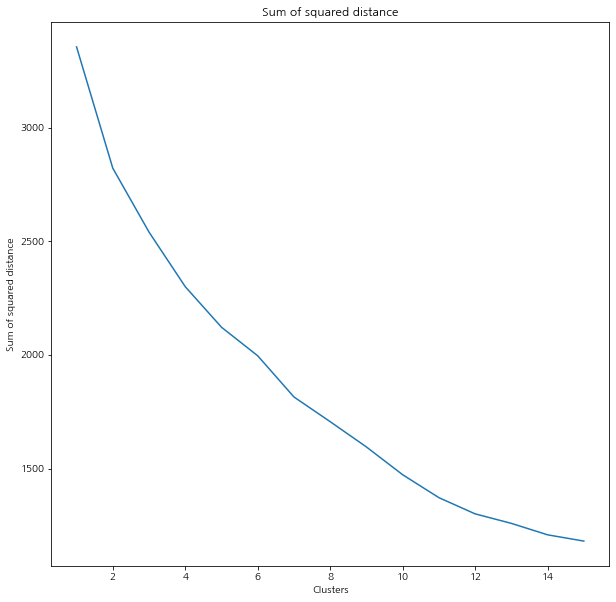

In [37]:
df_item_result = KMEANS(df_item_dummies,'item',5)
df_item_result

### df_all_dummies = 모든 변수 별 dummy df

In [38]:
pd.set_option('display.max_columns',None)
df_all_dummies = pd.concat([df_best_store,df_best_item],axis=1)
df_all_dummies['customer_id'] = sales_mode['customer_id']
df_all_dummies = pd.merge(df_all_dummies,member_features)
df_all_dummies.set_index('customer_id',inplace=True)
df_all_dummies = pd.get_dummies(df_all_dummies)
df_all_dummies


,gender,agegroup,customer_type,모바일_False,모바일_True,서귀포매장_False,서귀포매장_True,인터넷_False,인터넷_True,전화_False,전화_True,제주매장_False,제주매장_True,my_dong_구좌읍,my_dong_남원읍,my_dong_대정읍,my_dong_서귀포시,my_dong_성산읍,my_dong_안덕면,my_dong_애월읍,my_dong_제주시,my_dong_조천읍,my_dong_표선면,my_dong_한경면,my_dong_한림읍
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,
C118113,1,40,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
C118291,1,50,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
C118294,1,40,0,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
C118295,1,50,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
C118298,1,60,0,1,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C704198,1,30,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
C704239,1,50,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
C704271,1,40,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


,NumberofCluster,Error
0,1,301852.418875
1,2,92108.267890
2,3,52524.964657
3,4,15416.787271
4,5,5923.995552
5,6,4619.783052
6,7,3617.967639
7,8,3034.240479
8,9,2592.766362
9,10,2199.043600


,gender,agegroup,customer_type,모바일_False,모바일_True,서귀포매장_False,서귀포매장_True,인터넷_False,인터넷_True,전화_False,전화_True,제주매장_False,제주매장_True,my_dong_구좌읍,my_dong_남원읍,my_dong_대정읍,my_dong_서귀포시,my_dong_성산읍,my_dong_안덕면,my_dong_애월읍,my_dong_제주시,my_dong_조천읍,my_dong_표선면,my_dong_한경면,my_dong_한림읍,ClusterKmeans
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,
C118113,1,40,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,2
C118291,1,50,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,3
C118294,1,40,0,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,2
C118295,1,50,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,3
C118298,1,60,0,1,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C704198,1,30,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,4
C704239,1,50,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,3
C704271,1,40,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,2


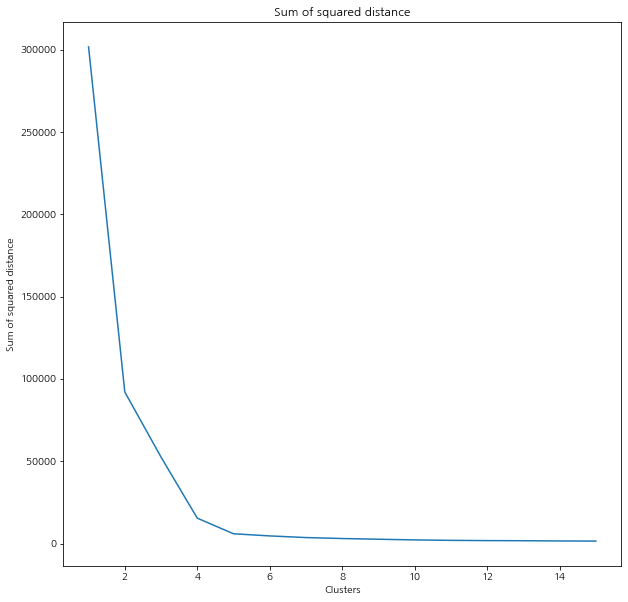

In [39]:
df_all_result = KMEANS(df_all_dummies,'all',5)
df_all_result

In [ ]:
sales.head()

In [ ]:
store_sales = sales.groupby('store_id').sum('purchase_amt').reset_index()
store_sales

In [ ]:
sns.barplot(x='store_id',y='purchase_amt',data=store_sales)

In [ ]:
test = sales.groupby('purchase_id').sum('purchase_amt')

In [ ]:
test